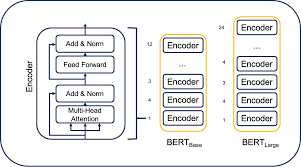

In [1]:

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


--2025-06-24 16:18:18--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2025-06-24 16:18:18 (18.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [7]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import torch.nn.functional as F

dropout = 0.0
learning_rate = 1e-3
epochs = 10
max_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
block_size = 32
eval_interval = 10
eval_iters = 200
n_embd = 64

with open('/content/input.txt', 'r', encoding='utf-8') as f:
    x = f.read()

class CharTokenizer:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.stoi = {ch: i for i, ch in enumerate(self.chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}

    def encode(self, text):
        return [self.stoi[ch] for ch in text]

    def decode(self, tokens):
        return ''.join([self.itos[token] for token in tokens])

vocab = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?:;'\n-&3$#@э!?*")

class PositionalEncoding(nn.Module):
  def __init__(self,d_model=128,max_len=16):
    super().__init__()
    self.pe = torch.zeros(1,max_len, d_model)
    self.d_model = 128
    self.max_len = 16
    #self.register_buffer('pe', pe)

  def forward(self, x):
        # x: (B, T, D)
    position = torch.arange(0, self.max_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-np.log(10000.0) / self.d_model))
    self.pe[:, 0::2] = torch.sin(position * div_term)
    self.pe[:, 1::2] = torch.cos(position * div_term)
    self.pe = self.pe.unsqueeze(0)
    return self.pe[:, :x.size(1)]





class PositionalEncoding(nn.Module):
    def __init__(self, d_model=128, max_len=512):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (B, T, D)
        returns: positional encoding (1, T, D)
        """
        return self.pe[:, :x.size(1), :].to(x.device)
"""def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y"""


class Feed_Forward(nn.Module):
  def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
  def forward(self,x):
      return self.net(x)

class Multi(nn.Module):
      def __init__(self):
        super().__init__()
        d_model=128
        num_heads=4
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_A = nn.Linear(d_model, d_model)
      def forward(self,Q,K,V):
        batch_size = Q.size(0)
        Q = self.W_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_A(output)

class Bert(nn.Module):
    def __init__(self, d_model=128, num_heads=4, block_size=16, vocab=vocab,vocab_size=len(vocab)):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding()

        self.mha = Multi()
        self.ff = Feed_Forward(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, idx):
        x1 = self.token_embedding(idx)  # (B, T, D)
        x2 = self.pos_enc(x1)
        x = x1 + x2
        x = self.norm1(self.mha(x,x,x) + x)
        x = self.norm2(self.ff(x) + x)
        logits = self.output(x)
        return logits
    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self.forward(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx


model = Bert().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [56]:

def train(model, data, optimizer, criterion, epochs=30, batch_size=32, block_size=32, device='cpu'):
    model.train()
    count  = 0
    for epoch in range(epochs):
        total_loss = 0
        for _ in range(len(data) // batch_size):
            ix = torch.randint(0, len(data) - block_size - 1, (batch_size,), device=device)
            x = torch.stack([data[i:i + block_size] for i in ix])
            y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
           # print('y',y)
            optimizer.zero_grad()
            logits = model(x)
            #print('log',logits)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1
         #   print(count)
            if count > 1500:
              break

        avg_loss = total_loss / (len(data) // batch_size)

        print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")


In [4]:
vocab = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?:;'\n-&3$#@э!?*")
tokenizer = CharTokenizer(vocab)

In [60]:
tokens = torch.tensor(tokenizer.encode(x[:100]), dtype=torch.long)
criterion = nn.CrossEntropyLoss()

In [65]:
print(x[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [61]:
train(
    model = model,
    data = tokens,
    optimizer = optimizer,
    criterion = criterion
)

Epoch 1: loss=0.0010
Epoch 2: loss=0.0003
Epoch 3: loss=0.0040
Epoch 4: loss=0.0071
Epoch 5: loss=0.0036
Epoch 6: loss=0.0002
Epoch 7: loss=0.0002
Epoch 8: loss=0.0002
Epoch 9: loss=0.0001
Epoch 10: loss=0.0001
Epoch 11: loss=0.0002
Epoch 12: loss=0.0002
Epoch 13: loss=0.0001
Epoch 14: loss=0.0001
Epoch 15: loss=0.0001
Epoch 16: loss=0.0001
Epoch 17: loss=0.0001
Epoch 18: loss=0.0000
Epoch 19: loss=0.0001
Epoch 20: loss=0.0001
Epoch 21: loss=0.0000
Epoch 22: loss=0.0000
Epoch 23: loss=0.0000
Epoch 24: loss=0.0000
Epoch 25: loss=0.0000
Epoch 26: loss=0.0000
Epoch 27: loss=0.0000
Epoch 28: loss=0.0000
Epoch 29: loss=0.0000
Epoch 30: loss=0.0000


In [41]:
def chat(model, tokenizer, prompt, max_new_tokens=50, device='cpu'):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(output_ids[0].tolist())
    return output_text


In [68]:

"""vocab = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?:;'\n-&3$#@э!?*")
tokenizer = CharTokenizer(vocab)
vocab_size = len(tokenizer.chars)
print(vocab_size)"""
#model = LlamaLike(vocab_size=vocab_size, d_model=128, num_heads=4, num_kv_groups=1)

# пример запроса
prompt = "Before we processed"
response = chat(model, tokenizer, prompt, max_new_tokens=100)
print(response)

Before we processed             mi p I I E O BEN I es re wBedre Sss p  S s N  S k k N P OB Bo   e I SBes k S s k S Bsss
